<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />


# Registration of an Image Stack

part of 

<font size = "4"> **pyTEMlib**, a **pycroscopy** library </font>


Notebook by 

Gerd Duscher

Materials Science & Engineering<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville


An introduction into Fourier Filtering of images.


## Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [32]:
import sys
from IPython.lib.deepreload import reload as dreload

try:
    import sidpy 
except ModuleNotFoundError:
    !pip3 install sidpy
if sidpy.__version__ < '0.0.3':
    !{sys.executable} -m pip install  --upgrade sidpy
    dreload(sidpy)
try:
    import pyNSID 
except ModuleNotFoundError:
    !{sys.executable} -m pip install  --upgrade pyNSID
try:
    import pyTEMlib
except ModuleNotFoundError:
    !{sys.executable} -m pip install  --upgrade pyTEMlib
if pyTEMlib.__version__ < '0.2020.10.3':
    !{sys.executable} -m pip install  --upgrade pyTEMlib
    dreload(pyTEMlib)   
from IPython.lib.deepreload import reload as dreload

import sys
!{sys.executable} -m pip install  --upgrade ""../dist/pyTEMlib-0.2020.10.3-py3-none-any.whl"
dreload(pyTEMlib) 

sidpy version:  0.0.3


## Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [1]:
%pylab --no-import-all notebook
%gui qt

import pyTEMlib
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools as it
print('pyTEMlib version: ', pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
pyTEMlib version:  0.2020.10.3


## Open File

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

C:\Users\gduscher\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<IPython.core.display.Javascript object>


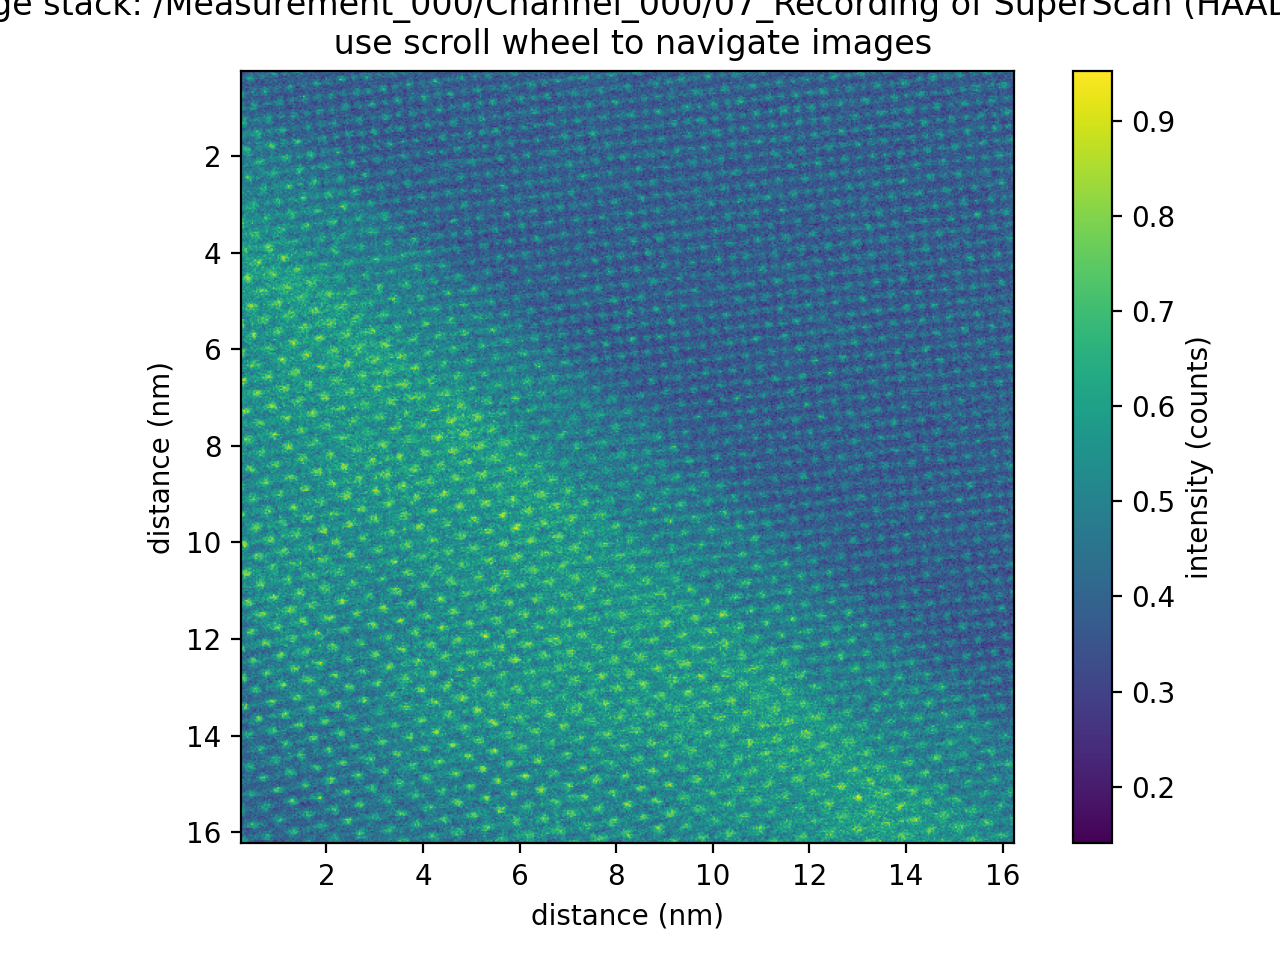

In [2]:
try:
    dataset.h5_dataset.file.close()
except:
    pass
dataset= ft.open_file()
if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need a stack of images here')
dataset.plot()

In [3]:
dataset

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<generic, shape=(25, 512, 512), dtype=float32, chunksize=(25, 512, 512), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
  frame:  stack (frame) of size (25,)
  y:  distance (nm) of size (512,)
  x:  distance (nm) of size (512,)
 with metadata: ['DIMENSION_LABELS', 'DIMENSION_LIST', 'data_type', 'main_data_name', 'modality', 'nsid_version', 'quantity', 'source', 'units']

## First: Rigid Registration

If this is an image stack we need to register and add the images. 

Using sub-pixel accuracy registration determination method of:

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). [DOI:10.1364/OL.33.000156](https://www.doi.org/%2010.1364/OL.33.000156)

as implemented in ``phase_cross_correlation`` function by ``scikit-image`` in the [registration](https://scikit-image.org/docs/dev/api/skimage.registration.html) package. 

Stack contains  25  images, each with 512  pixels in x-direction and  512  pixels in y-direction


<IPython.core.display.Javascript object>


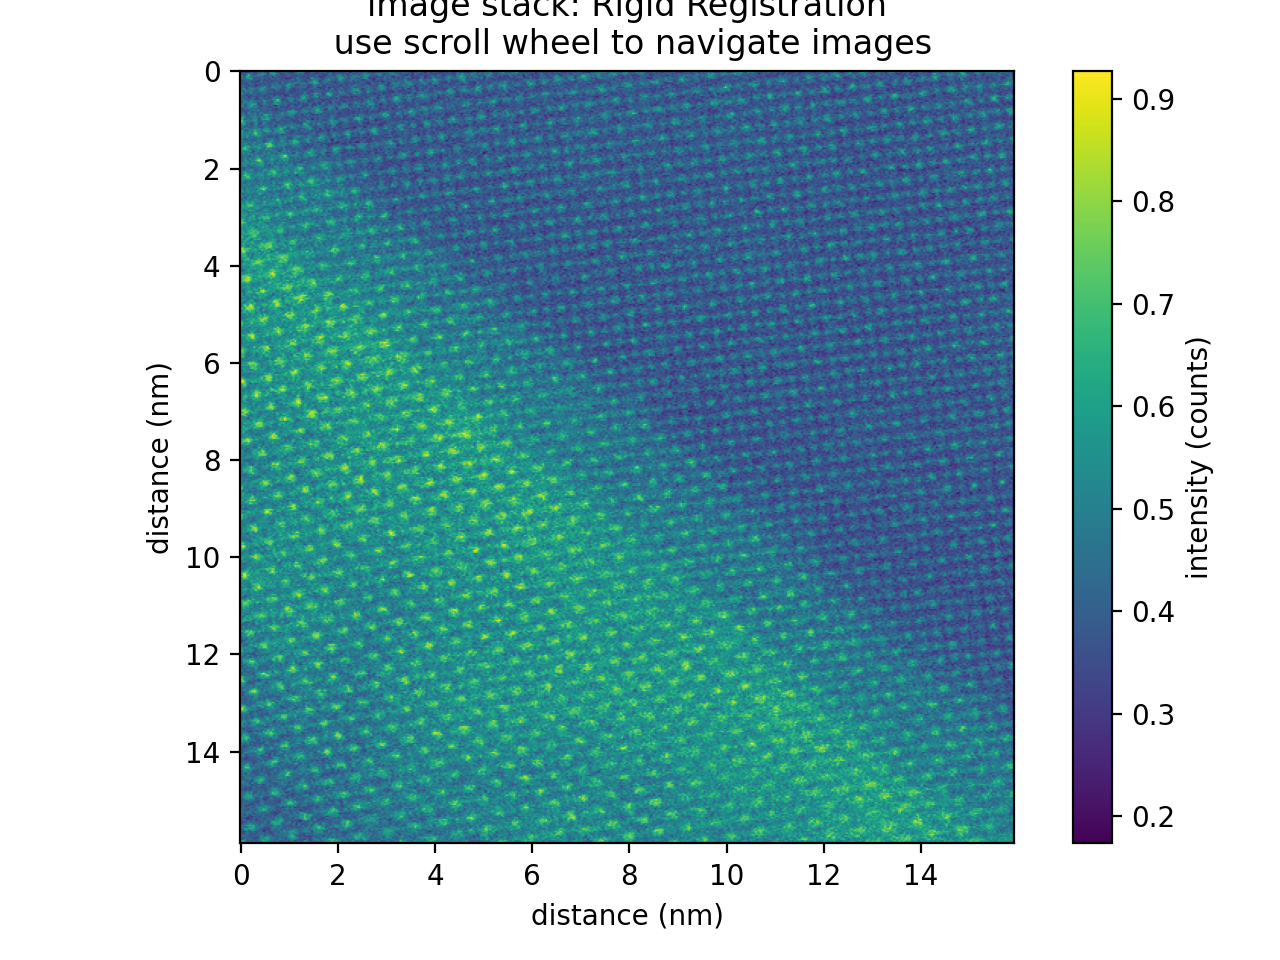

In [4]:
rig_reg_dataset = it.rigid_registration(dataset)

rig_reg_dataset.plot()

### Determine Quality of Rigid Registration

First we fit a polynom of degree **polynom_degree** onto the drift of x and y separately.

The Nion STEMs are extremly stable and sub_pixel drift per image can be achieved.

A pixel of size 30pm distributed over 512 pixel (the size of many images) is obviously negletible.

<IPython.core.display.Javascript object>


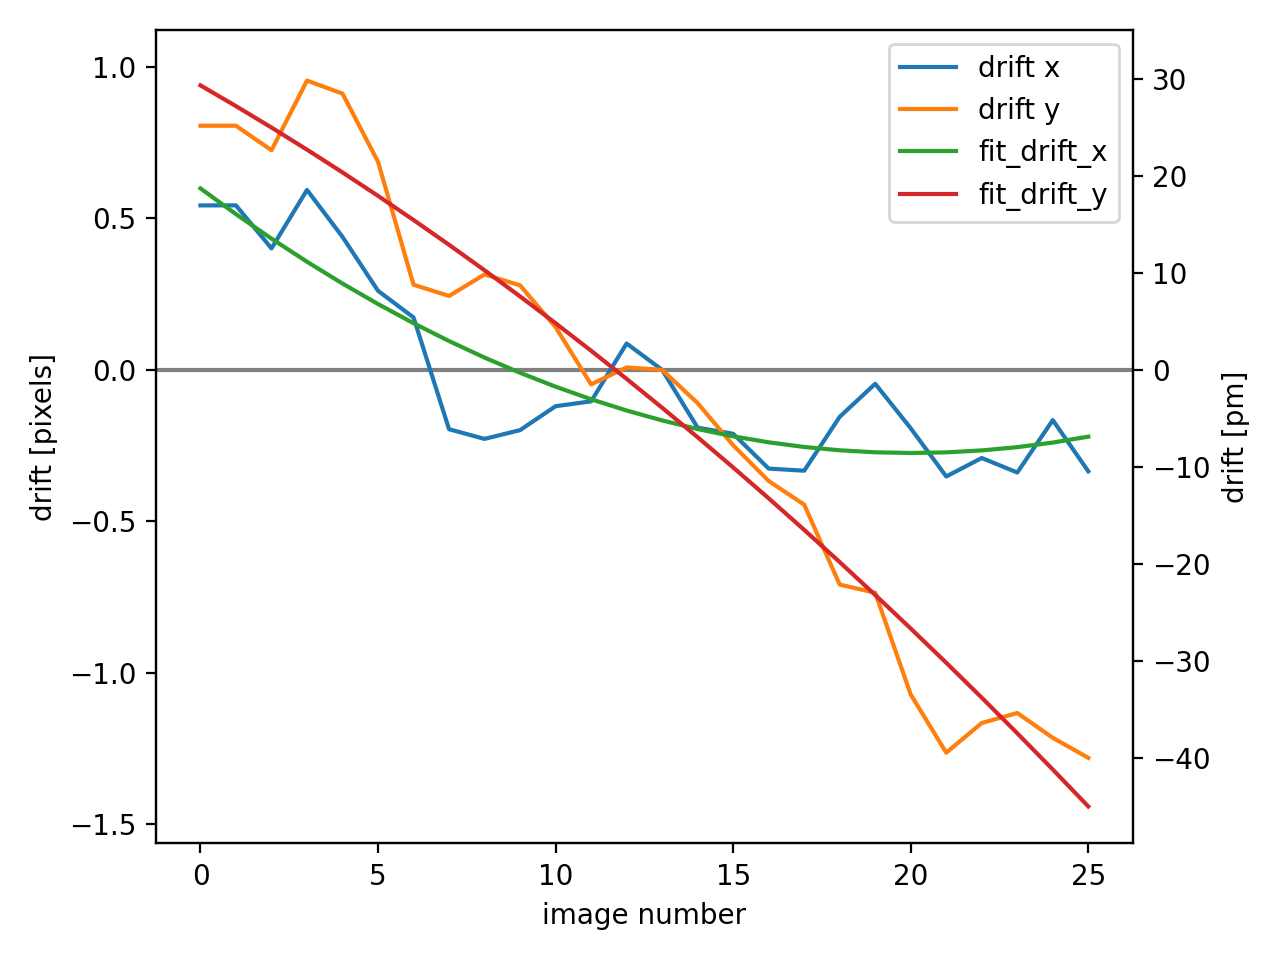

In [6]:
scale_x = ft.get_slope(rig_reg_dataset.x.values)*1000.
drift = rig_reg_dataset.metadata['drift']
x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...
line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)


plt.figure()
# plot drift and fit of drift
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')
plt.legend();

# set second axis in pico meter
ax_pixels = plt.gca()
ax_pixels.step(1, 1)
ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()
ax_pm.set_ylim(x_1*scale_x, x_2*scale_x)

# add labels
ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()


### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.20


<IPython.core.display.Javascript object>


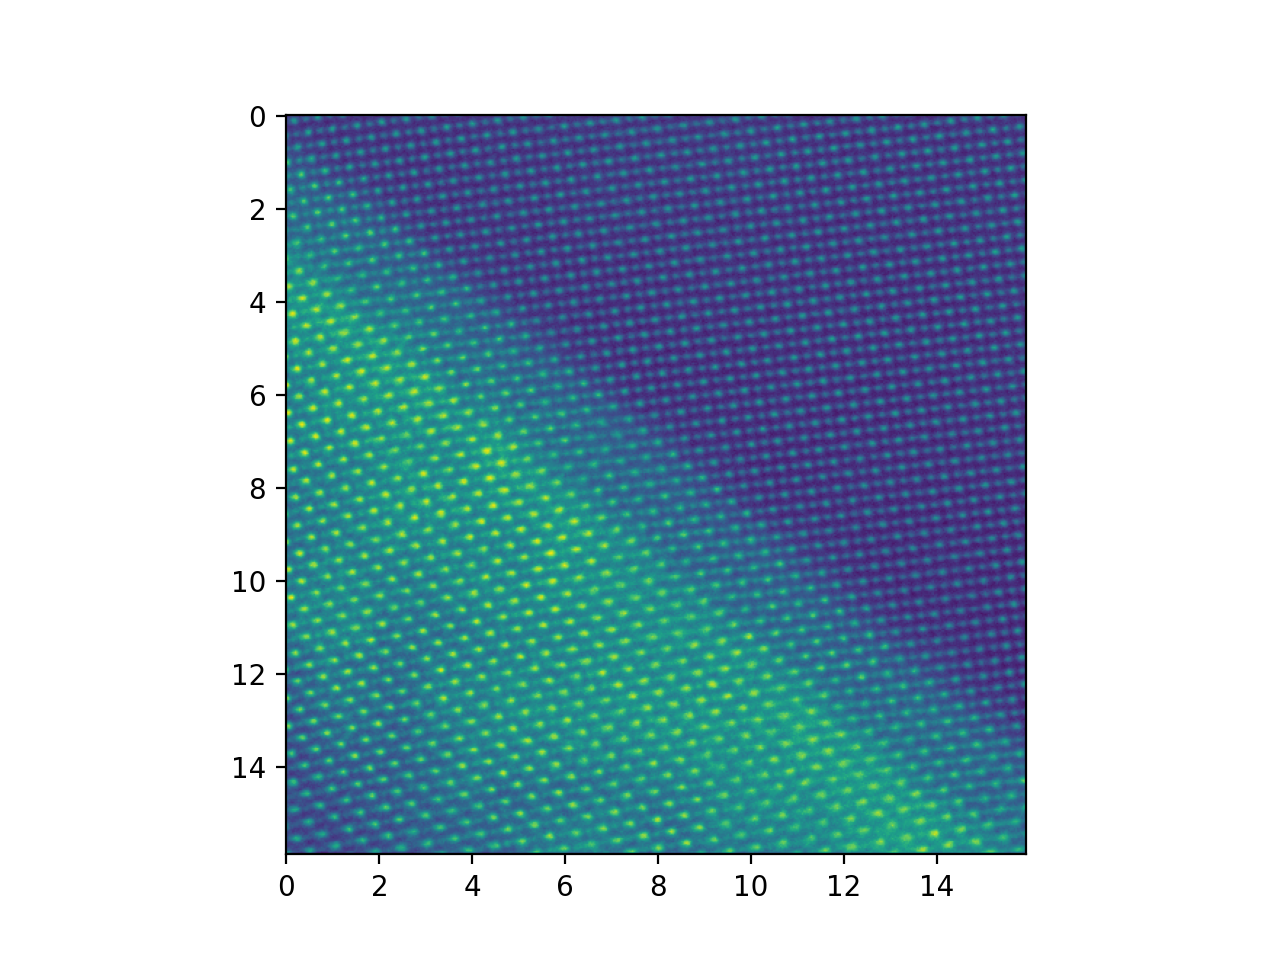

In [23]:
image = rig_reg_dataset.sum(axis=0)
extent = rig_reg_dataset.get_extent([1,2])

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')
plt.figure()
plt.imshow(image.T, extent = extent);

### Log Rigid Registration

We store the croped image-stack and drift-data here.

In [9]:
registration_channel = ft.log_results(dataset.h5_dataset.parent, rig_reg_dataset)

<HDF5 group "/Measurement_000/Channel_000/Log_000" (0 members)> Rigid Registration


## Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

<HDF5 group "/Measurement_000/Channel_000/Log_001" (0 members)> Non_Rigid Registration


C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_io.py:90: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:Non-Rigid Registration to Non_Rigid Registration
  warn('main_data_name should not contain the "-" character. Reformatted name from:{} to '


<IPython.core.display.Javascript object>


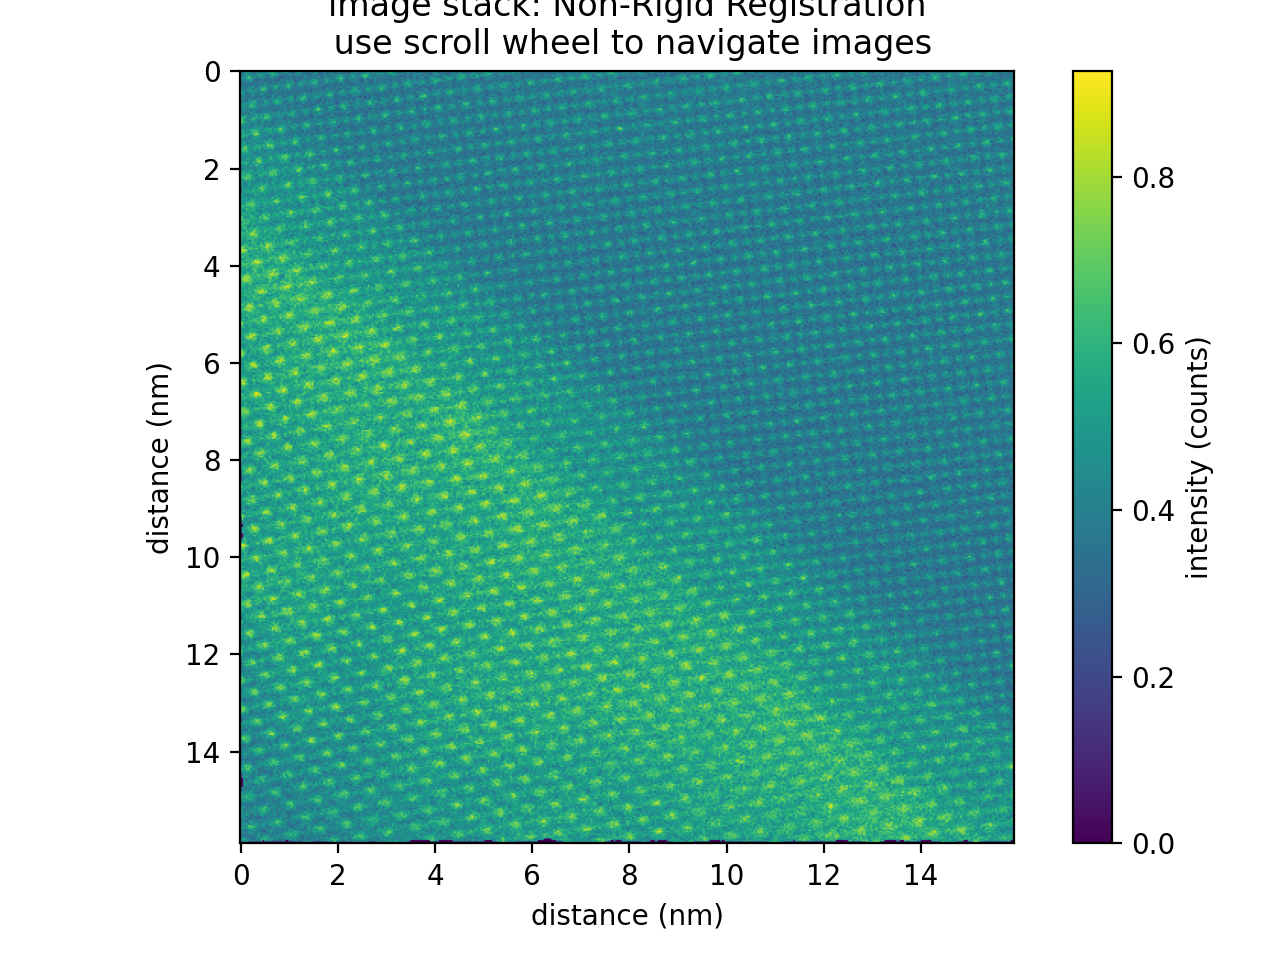

In [13]:
non_rigid_registered = it.demon_registration(rig_reg_dataset)

non_rigid_registered.plot()

### Contrast
The image should have improved in contrast and signal noise ratio.

Contrast = 0.21


<IPython.core.display.Javascript object>


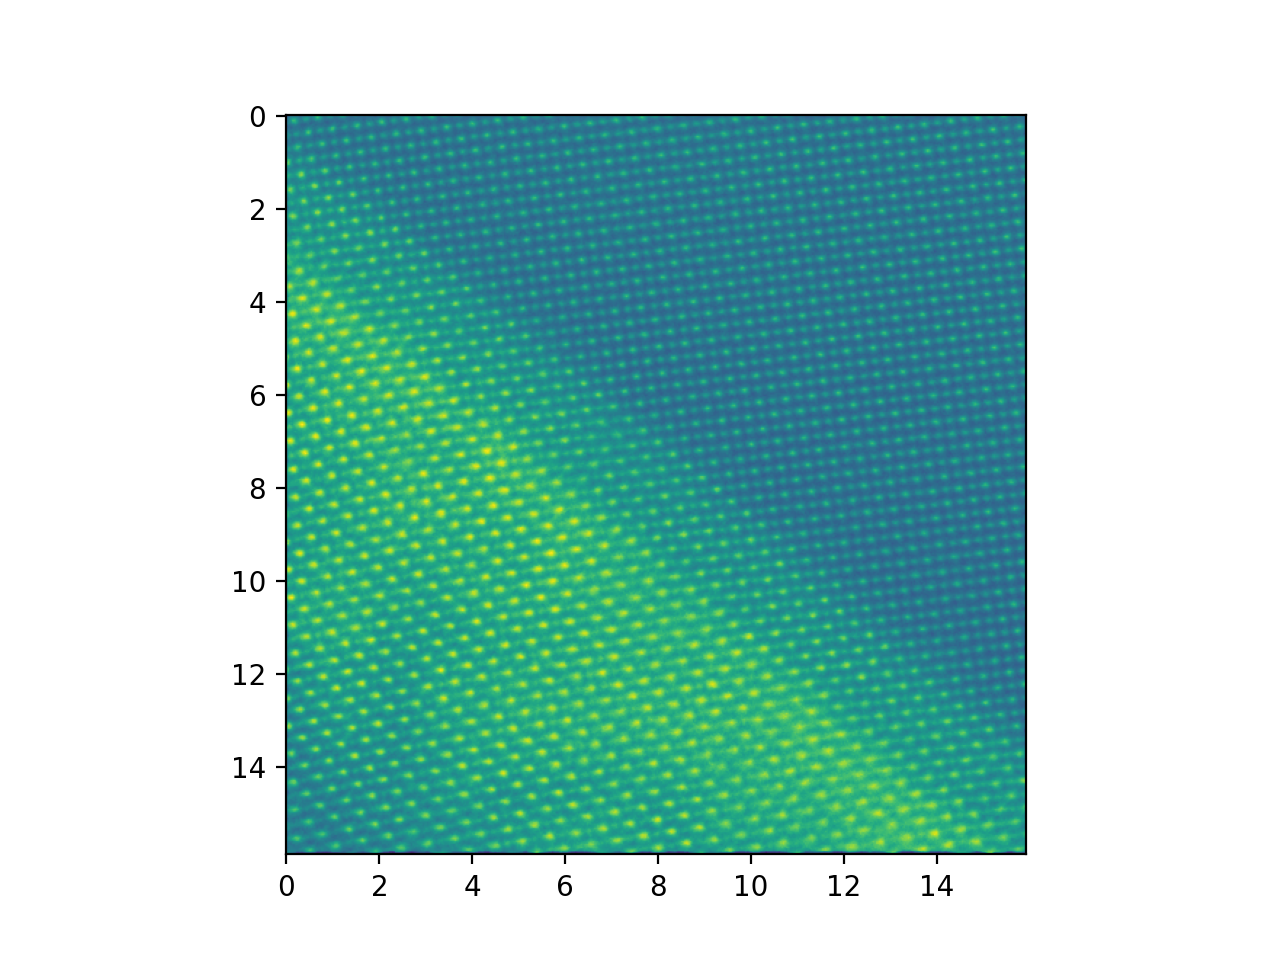

In [14]:
image = non_rigid_registered.sum(axis=0)
extent = non_rigid_registered.get_extent([1,2])

print(f'Contrast = {np.std(np.array(image))/np.average(np.array(image)):.2f}')

plt.figure()
plt.imshow(image.T, extent = extent);

Let's see what we did - In Fourier space, of course.

### Log Non-Rigid Registration

In [39]:
registration_channel = ft.log_results(dataset.h5_dataset.parent, non_rigid_registered)

<HDF5 group "/Measurement_000/Channel_000/Log_000" (0 members)> Fourier filtered 05_SI Survey Image


A tree-like plot of the file

In [16]:
ft.h5_tree(dataset)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ 07_Recording of SuperScan (HAADF)
    ├ Log_000
      -------
      ├ Rigid Registration
      ├ frame
      ├ metadata
        --------
      ├ original_metadata
        -----------------
      ├ x
      ├ y
    ├ Log_001
      -------
      ├ Non_Rigid Registration
      ├ frame
      ├ metadata
        --------
      ├ original_metadata
        -----------------
      ├ x
      ├ y
    ├ frame
    ├ metadata
      --------
    ├ original_metadata
      -----------------
    ├ x
    ├ y


## Comparison of Different Dataset

A convenient function to select a dataset (for further processing, visualization or whatever)

In [18]:
choose_image = ft.ChooseDataset(dataset.h5_dataset.parent)

Dropdown(description='Select image:', options=('Log_001/Non_Rigid Registration', 'Log_000/Rigid Registration',…

The selected dataset can then easily be plotted

<IPython.core.display.Javascript object>


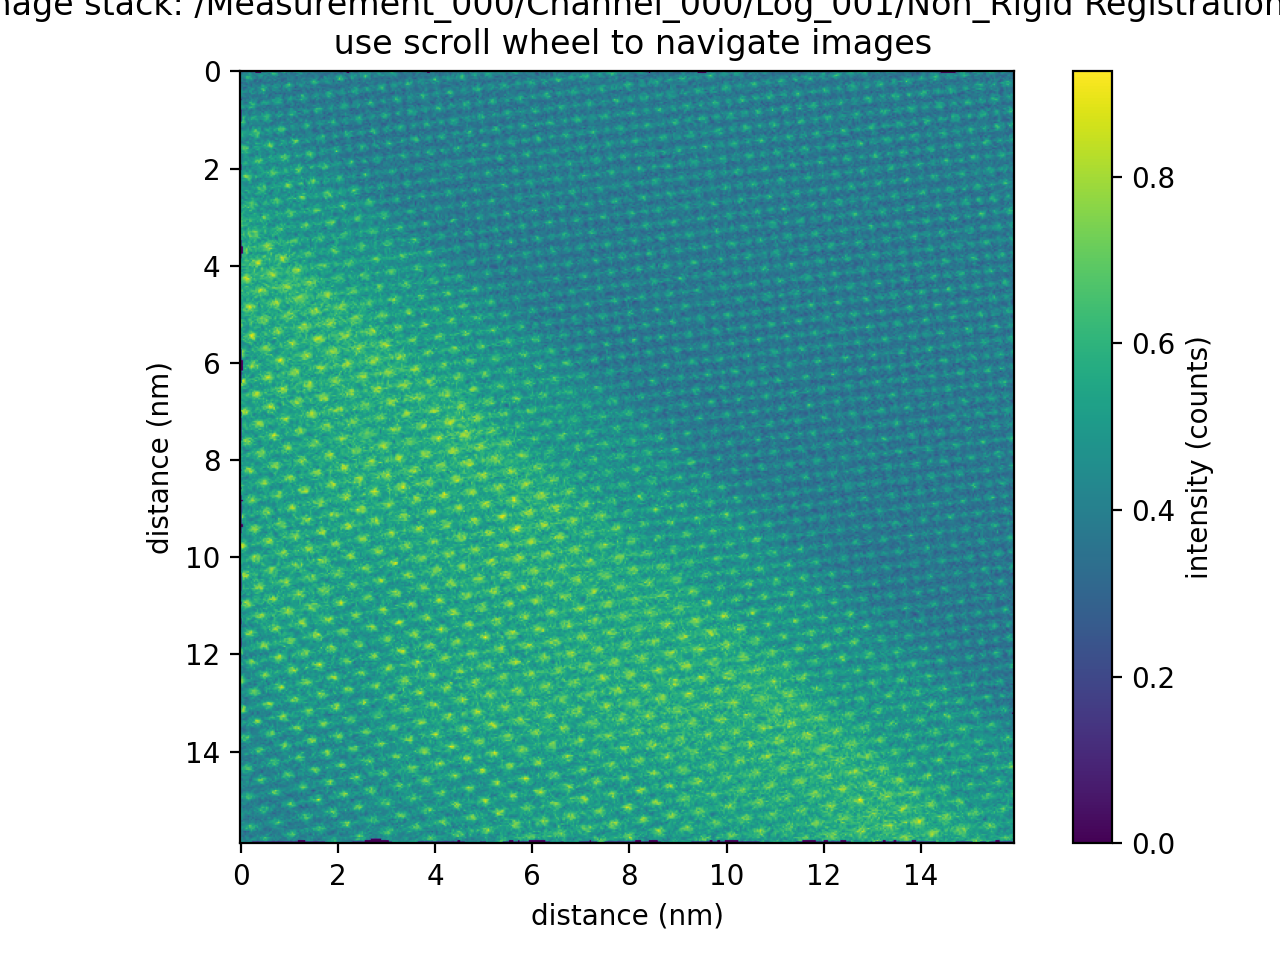

In [20]:
choose_image.dataset.plot()

## Close File
let's close the file but keep the filename

In [22]:
filename = registration_channel.file.filename
registration_channel.file.close()